# Code to generate Figure 1 

In [1]:
%cd ../../src/gz21_ocean_momentum
import os
from utils import select_experiment, select_run
from analysis.utils import plot_dataset, GlobalPlotter, plot_training_subdomains
from data.utils import load_training_datasets
import mlflow
from mlflow.tracking import MlflowClient
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np

import cmocean
cmap_solar = cmocean.cm.solar
cmap_balance = cmocean.cm.balance

mlruns_path=os.path.join(os.getcwd(), '../../mlruns')
%env MLFLOW_TRACKING_URI $mlruns_path

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum
To load the net from the paper, use the function load_paper_net().
env: MLFLOW_TRACKING_URI=/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum/../../mlruns


### Select an experiment by experiment ID, and get the associated run

In [2]:
exp_id, exp_name = select_experiment()

400567430961551461 :  test4
497746281881301089 :  test3
568040818937566888 :  test2
302083951441703666 :  testrun
0 :  Default


Select the id of an experiment:  400567430961551461


In [3]:
experiment_id = mlflow.get_experiment_by_name(exp_name).experiment_id
cols = ['params.CO2', ]
run = select_run(cols=cols, experiment_ids=(experiment_id,))

                             run_id       experiment_id params.CO2
0  776f134476b64e6dafb543acb441de55  400567430961551461          1


Select row number (first column) 0


### Get the data set of the selected run 

In [4]:
ml_client = MlflowClient()
data_fname = ml_client.download_artifacts(run.run_id, 'forcing')
data = xr.open_zarr(data_fname)
#data = data.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))

### Define a plotter which plots the dataset as a map, and the areas for the training, and execute the plotting

\begin{table}[]
\begin{tabular}{lcccc}
subdomain & latitude range               & longitude range & training & validation \\ 
A  &     35.0\degree, 50.0\degree           &         -50.0\degree, -20.0\degree        & X        & X \\
B  &     -40.0\degree, -25.0\degree           &         -180.0\degree, -162.0\degree        & X        & X \\
C  &     -20.0\degree, -5.0\degree           &         -110.0\degree, -92.0\degree        & X        & X \\
D  &     -0.0\degree, 15.0\degree           &         -48.0\degree, -30.0\degree        & X        & X \\
\end{tabular}
\end{table}



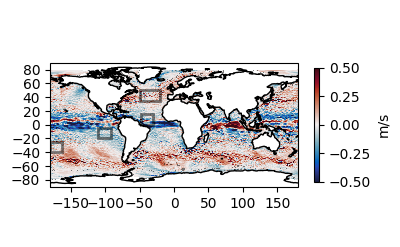

<GeoAxes: >

In [5]:
from data.pangeo_catalog import get_patch

#run = select_run(experiment_ids=('497746281881301089'))
run_id = run.run_id

from cartopy.crs import PlateCarree
from data.pangeo_catalog import get_patch, get_whole_data
from scipy.ndimage import gaussian_filter
from matplotlib import colors
import matplotlib.pyplot as plt

from importlib import reload
reload(plt)

%matplotlib widget
#%matplotlib inline #this option does not work with jupyterlab

CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'


class GlobalPlotter:
    """General class to make plots for global data. Handles masking of
    continental data + showing a band near coastlines."""

    def __init__(self, margin: int = 10, cbar: bool = True, ice: bool = True):
        self.mask = self._get_global_u_mask()
        self.margin = margin
        self.cbar = cbar
        self.ticks = dict(x=None, y=None)
        self.ice = ice

    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, value):
        self._mask = value

    @property
    def borders(self):
        return self._borders

    @borders.setter
    def borders(self, value):
        self._borders = value

    @property
    def margin(self):
        return self._margin

    @margin.setter
    def margin(self, margin):
        self._margin = margin
        self.borders = self._get_continent_borders(self.mask, self.margin)

    @property
    def x_ticks(self):
        return self.ticks['x']

    @x_ticks.setter
    def x_ticks(self, value):
        self.ticks['x'] = value

    @property
    def y_ticks(self):
        return self.ticks['y']

    @y_ticks.setter
    def y_ticks(self, value):
        self.ticks['y'] = value

    def plot(self, u: xr.DataArray = None, projection_cls=PlateCarree,
             lon: float = -100.0, lat: float = None, ax=None, animated=False,
             borders_color='grey', borders_alpha=1., **plot_func_kw):
        """
        Plots the passed velocity component on a map, using the specified
        projection. Uses the instance's mask to set as nan some values.

        Parameters
        ----------
        u : xr.DataArray
            Velocity array. The default is None.
        projection : Projection
            Projection used for the 2D plot.
        lon : float, optional
            Central longitude. The default is -100.0.
        lat : float, optional
            Central latitude. The default is None.

        Returns
        -------
        None.

        """

        fig = plt.figure()
        projection = projection_cls(lon)
        if ax is None:
            ax = plt.axes(projection=projection)
        mesh_x, mesh_y = np.meshgrid(u['xu_ocean'], u['yu_ocean'])
        if u is not None:
            extra = self.mask.isel(xu_ocean=slice(0, 10))
            extra['xu_ocean'] = extra['xu_ocean'] + 360
            mask = xr.concat((self.mask, extra), dim='xu_ocean')
            mask = mask.interp({k: u.coords[k] for k in ('xu_ocean',
                                                         'yu_ocean')})
            u = u * mask
            im = ax.pcolormesh(mesh_x, mesh_y, u.values,
                               transform=PlateCarree(),
                               animated=animated, **plot_func_kw)
        if self.x_ticks is not None:
            ax.set_xticks(self.x_ticks)
        if self.y_ticks is not None:
            ax.set_yticks(self.y_ticks)
        ax.set_global()
        ax.coastlines()
        # "Gray-out" near continental locations
        if self.margin > 0:
            extra = self.borders.isel(longitude=slice(0, 10))
            extra['xu_ocean'] = extra['xu_ocean'] + 360
            borders = xr.concat((self.borders, extra), dim='xu_ocean')
            borders = borders.interp({k: u.coords[k]
                                     for k in ('xu_ocean', 'yu_ocean')})
            borders_cmap = colors.ListedColormap([borders_color, ])
            ax.pcolormesh(mesh_x, mesh_y, borders, animated=animated,
                          transform=PlateCarree(), alpha=borders_alpha,
                          cmap=borders_cmap)
        # Add locations of ice
        if self.ice:
            ice = self._get_ice_border()
            ice = xr.where(ice, 1., 0.)
            ice = ice.interp({k: u.coords[k] for k in ('xu_ocean',
                                                       'yu_ocean')})
            ice = xr.where(ice != 0, 1., 0.)
            ice = abs(ice.diff(dim='xu_ocean')) + abs(ice.diff(dim='yu_ocean'))
            ice = xr.where(ice != 0., 1, np.nan)
            ice_cmap = colors.ListedColormap(['black', ])
            ax.pcolormesh(mesh_x, mesh_y, ice, animated=animated,
                          transform=PlateCarree(), alpha=0.5,
                          cmap=ice_cmap)
        if u is not None and self.cbar:
            cbar = plt.colorbar(im, shrink=0.6)
            cbar.set_label('m/s')
        return ax

    @staticmethod
    def _get_global_u_mask(factor: int = 4, base_mask: xr.DataArray = None):
        """
        Return the global mask of the low-resolution surface velocities for
        plots. While the coarse-grained velocities might be defined on
        continental points due to the coarse-graining procedures, these are
        not shown as we do not use them -- the mask for the forcing is even
        more restrictive, as it removes any point within some margin of the
        velocities mask.

        Parameters
        ----------
        factor : int, optional
            Coarse-graining factor. The default is 4.

        base_mask: xr.DataArray, optional
            # TODO
            Not implemented for now.

        Returns
        -------
        None.

        """
        if base_mask is not None:
            mask = base_mask
        else:
            _, grid_info = get_whole_data(CATALOG_URL, 0)
            mask = grid_info['wet']
            mask = mask.coarsen(dict(xt_ocean=factor, yt_ocean=factor))
        mask_ = mask.max()
        mask_ = mask_.where(mask_ > 0.1)
        mask_ = mask_.rename(dict(xt_ocean='xu_ocean', yt_ocean='yu_ocean'))
        return mask_.compute()

    @staticmethod
    def _get_ice_border():
        """Return an xarray.DataArray that indicates the locations of ice
        in the oceans. """
        temperature, _ = get_patch(CATALOG_URL, 1, None, 0,
                                        'surface_temp')
        temperature = temperature.rename(dict(xt_ocean='xu_ocean',
                                              yt_ocean='yu_ocean'))
        temperature = temperature['surface_temp'].isel(time=0)
        ice = xr.where(temperature <= 0., True, False)
        return ice

    @staticmethod
    def _get_continent_borders(base_mask: xr.DataArray, margin: int):
        """
        Returns a boolean xarray DataArray corresponding to a mask of the
        continents' coasts, which we do not process.
        Hence margin should be set according to the model.

        Parameters
        ----------
        mask : xr.DataArray
            Mask taking value 1 where coarse velocities are defined and used
            as input and nan elsewhere.
        margin : int
            Margin imposed by the model used, i.e. number of points lost on
            one side of a square.

        Returns
        -------
        mask : xr.DataArray
            Boolean DataArray taking value True for continents.

        """
        assert margin >= 0, 'The margin parameter should be a non-negative' \
                            ' integer'
        assert base_mask.ndim <= 2, 'Velocity array should have two'\
                                    ' dims'
        # Small trick using the guassian filter function
        mask = xr.apply_ufunc(lambda x: gaussian_filter(x, 1., truncate=margin),
                              base_mask)
        mask = np.logical_and(np.isnan(mask),  ~np.isnan(base_mask))
        mask = mask.where(mask)
        return mask.compute()

plotter = GlobalPlotter(cbar=True, margin=0)
plotter.x_ticks = np.arange(-150., 151., 50)
plotter.y_ticks = np.arange(-80., 81., 20)
plot_training_subdomains(plotter, bg_variable=data['usurf'].isel(time=0), facecolor='green', edgecolor='black', linewidth=2, fill=False, vmin=-0.5, vmax=0.5, lon=0., cmap=cmap_balance)


In [ ]:
plt.savefig('figure1b.jpg', dpi=250)